In [1]:
# Library needed
from numpy import expand_dims, dot, asarray, array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import save_model, load_model
from matplotlib import pyplot
from tqdm import tqdm
import random
import numpy as np
import os
import time
import cv2
import h5py

Using TensorFlow backend.


In [2]:
# Configuration
IMG_H = 300 
IMG_W = 300
EPOCHS = 10
BATCH_SIZE = 32
SPLIT = 0.2
SAMPLE = 300
AUG_NUM = 3 # aug 5
SHIFT_RANGE = 0.1
ROTATION_RANGE = 10
DROPOUT_RATE=0.3
MODEL_NAME = "scratch_many.h5"

CATEGORIES = ["rendah", "tinggi"]

In [3]:
def create_augmentation(filename, label):
    # load the image
    img = load_img(filename)
    # convert to numpy array
    data = img_to_array(img)
    # expand dimension to one sample
    samples = expand_dims(data, 0)
    # create image data augmentation generator
    datagen = ImageDataGenerator(rotation_range=ROTATION_RANGE,
        width_shift_range=SHIFT_RANGE,
        height_shift_range=SHIFT_RANGE,
        horizontal_flip=True)
    # prepare iterator
    it = datagen.flow(samples)
    # augmentation list of this image 
    aug_list = []
    # generate samples and plot
    for i in range(AUG_NUM):
        # generate batch of images
        batch = it.next()
        # convert to unsigned integers for viewing
        image = batch[0]
        gray = dot(image[...,:3], [0.299, 0.587, 0.144])
        gray_nd_array = asarray(gray)
        resized_gray_nd_array = cv2.resize(gray_nd_array, (IMG_H, IMG_W))
        aug_list.append([resized_gray_nd_array, CATEGORIES.index(label)])
    return aug_list
    

# Loading & creating augmentation of the data

In [4]:
training_data = []
cwd = os.getcwd()
data_path = os.path.join(cwd, "databaru")
# untuk tiap folder (rendah & tinggi)
for category in CATEGORIES:
    # path folder ini
    dirpath = os.path.join(data_path, category)
    # dapatkan list nama file 
    filenames = os.listdir(dirpath)
    # sampling sebanyak jumlah SAMPLE yang ditentukan di konfigurasi
    #filenames = random.choices(filenames, k=SAMPLE)

    with tqdm(total=len(filenames)) as pbar:
        pbar.set_description("Doing augmentation for category  {}".format(category))
        for filename in filenames:
            try:
                filepath = os.path.join(dirpath, filename)
                aug_list = create_augmentation(filepath, category)
                training_data += aug_list
            except Exception as e:
                print(str(e))
            pbar.update(1)


Doing augmentation for category  tinggi: 100%|██████████| 420/420 [01:10<00:00,  5.96it/s]


In [5]:
# Shuffling the training data to avoid bias due to sequencial learning 
random.shuffle(training_data)
random.shuffle(training_data)

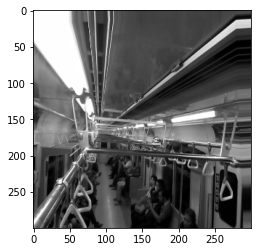

rendah


rendah


rendah


tinggi


rendah


rendah


rendah


tinggi


rendah


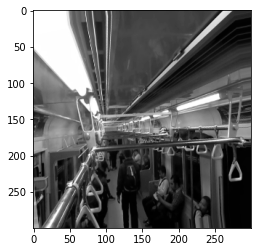

rendah


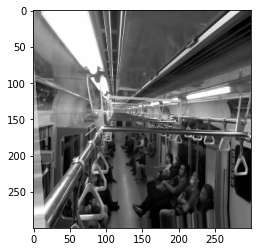

rendah


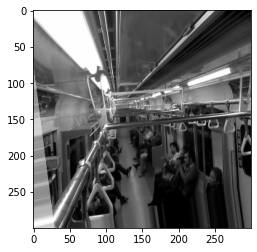

rendah


tinggi


tinggi


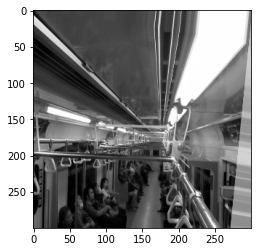

rendah


rendah


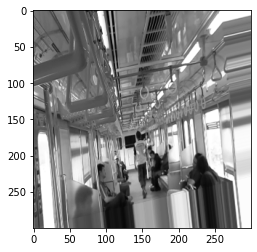

rendah


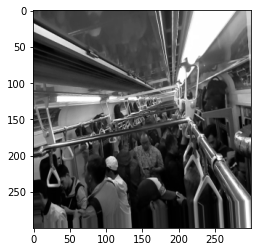

tinggi


rendah


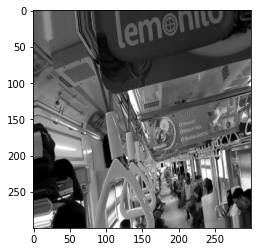

rendah


In [6]:
# try showing the image of the preprocessed data
for i in range(0, 20):
    ndarr = training_data[i][0]
    pyplot.imshow(ndarr, cmap="gray")
    pyplot.show()
    print(CATEGORIES[training_data[i][1]])

In [7]:
len(training_data)

4872

In [8]:
training_data[2][0].shape

(300, 300)

In [9]:
x = [] # Features 
y = [] # Labels

for data in training_data:
    x.append(data[0])
    y.append(data[1])

x = array(x).reshape(-1, IMG_H, IMG_W, 1)

# normalize
x = x/255.0

In [10]:
model = Sequential()

model.add(Conv2D(64, (3,3), input_shape = x.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(DROPOUT_RATE))

model.add(Conv2D(64, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(DROPOUT_RATE))

model.add(Flatten())
model.add(Dense(64))
model.add(Dropout(DROPOUT_RATE))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

x = array(x)
y = array(y)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

# model.fit(x, y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=SPLIT, callbacks=[es])
model.fit(x, y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=SPLIT)

Train on 3897 samples, validate on 975 samples
Epoch 1/10
3897/3897 [==============================] - 180s 46ms/sample - loss: 1.1943 - accuracy: 0.8199 - val_loss: 0.1173 - val_accuracy: 0.9590
Epoch 2/10
3897/3897 [==============================] - 181s 46ms/sample - loss: 0.0855 - accuracy: 0.9679 - val_loss: 0.1396 - val_accuracy: 0.9549
Epoch 3/10
3897/3897 [==============================] - 181s 46ms/sample - loss: 0.0369 - accuracy: 0.9879 - val_loss: 0.0367 - val_accuracy: 0.9908
Epoch 4/10
3897/3897 [==============================] - 181s 47ms/sample - loss: 0.0151 - accuracy: 0.9951 - val_loss: 0.0277 - val_accuracy: 0.9897
Epoch 5/10
3897/3897 [==============================] - 181s 46ms/sample - loss: 0.0137 - accuracy: 0.9959 - val_loss: 0.0467 - val_accuracy: 0.9795
Epoch 6/10
3897/3897 [==============================] - 181s 46ms/sample - loss: 0.0707 - accuracy: 0.9749 - val_loss: 0.0961 - val_accuracy: 0.9662
Epoch 7/10
3897/3897 [==============================] - 181

In [11]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x, y)
print('Test accuracy:', test_acc)

4872/4872 [==============================] - 38s 8ms/sample - loss: 0.0075 - accuracy: 0.9984
Test accuracy: 0.99835795


In [12]:
# save the model 
save_model(model, MODEL_NAME)

In [13]:
# load the model
# path = MODEL_NAME 
# model_obj = h5py.File(path, "r+")
# model = load_model(model_obj, compile=False)
# model_obj.close()

# Testing
# Function to prepare the image to be predicted 
def prepare(filepath):
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_H, IMG_W))
    return new_array.reshape(-1, IMG_H, IMG_W, 1)

# Function to predict the image 
def predict(filepath):
    prediction = model.predict([prepare(filepath)])
    print(CATEGORIES[int(prediction[0][0])])
    

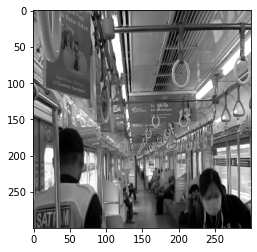

rendah


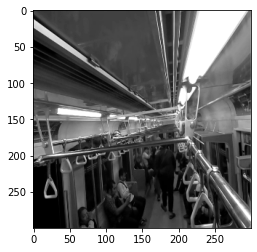

rendah


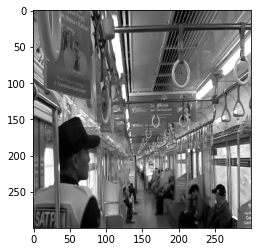

rendah


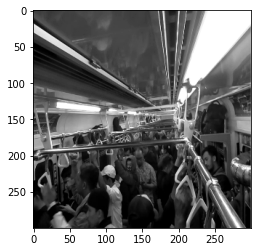

tinggi


rendah


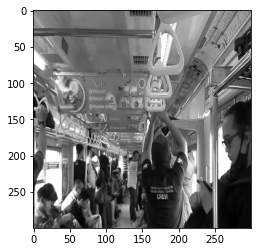

rendah


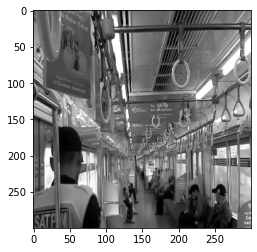

rendah


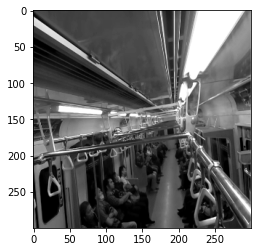

rendah


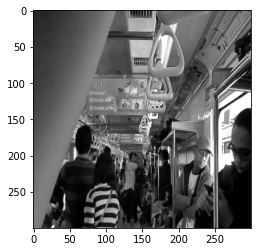

rendah


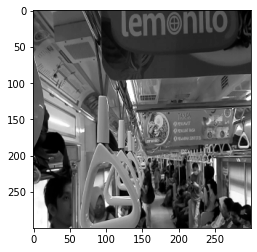

rendah


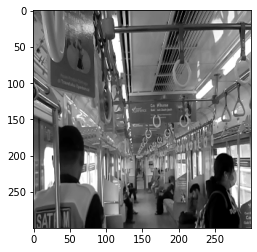

rendah


rendah


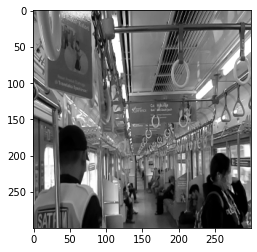

rendah


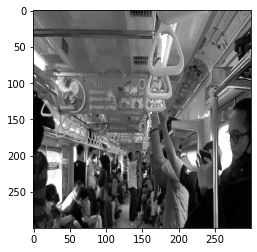

rendah


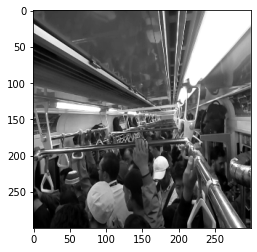

rendah


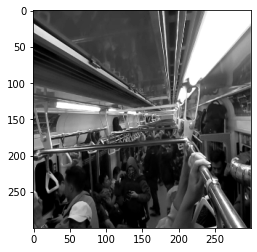

tinggi


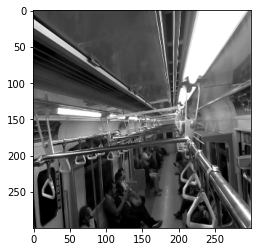

rendah


tinggi


rendah


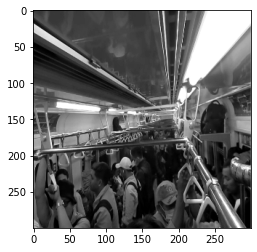

rendah


In [14]:
# Directory where the images to be predicted are stored
filepath = "test"

for img in os.listdir(filepath): 
    path = os.path.join(filepath, img)
    img_array = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_H, IMG_W))
    pyplot.imshow(new_array, cmap="gray")
    pyplot.show()
    predict(path)

label
rendah
prediction
rendah


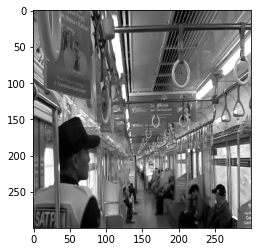

label
rendah
prediction
rendah


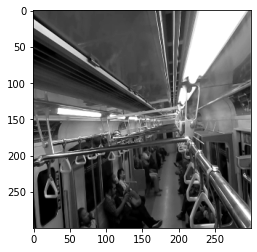

label
rendah
prediction
rendah


label
rendah
prediction
rendah


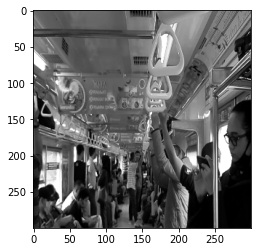

label
rendah
prediction
rendah


label
rendah
prediction
rendah


label
rendah
prediction
rendah


label
rendah
prediction
rendah


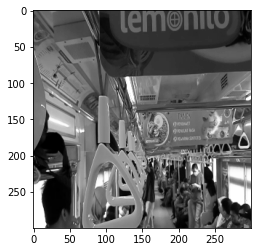

label
rendah
prediction
rendah


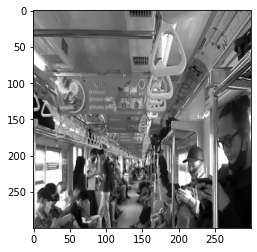

label
rendah
prediction
rendah


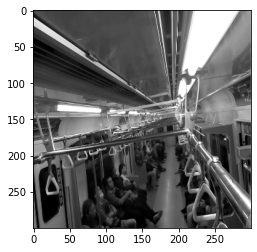

label
rendah
prediction
rendah


label
rendah
prediction
rendah


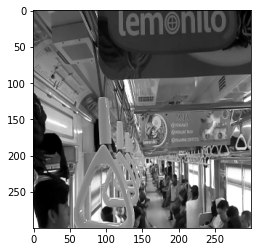

label
rendah
prediction
rendah


label
rendah
prediction
rendah


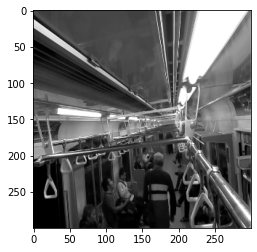

label
rendah
prediction
rendah


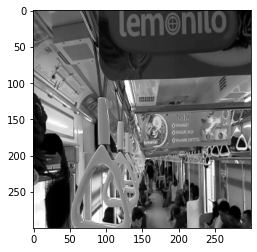

label
rendah
prediction
rendah


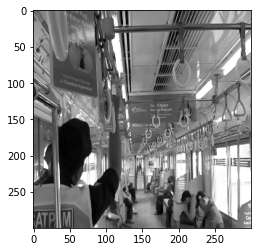

label
rendah
prediction
rendah


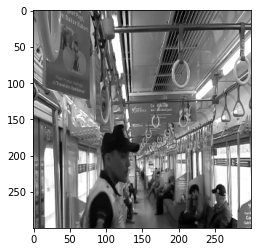

label
rendah
prediction
rendah


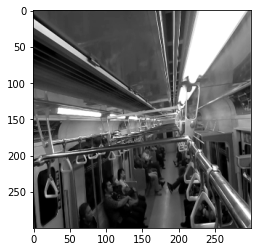

label
rendah
prediction
rendah


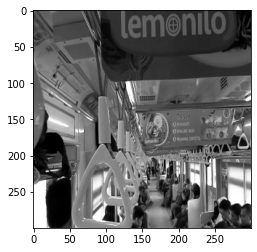

label
rendah
prediction
rendah


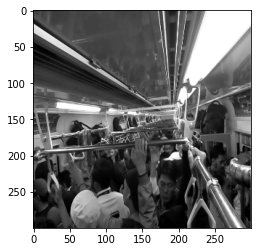

label
tinggi
prediction
tinggi


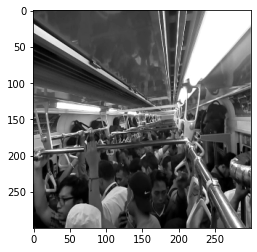

label
tinggi
prediction
tinggi


label
tinggi
prediction
rendah


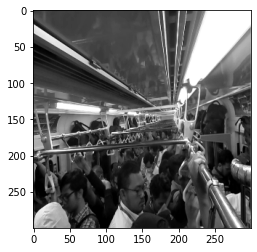

label
tinggi
prediction
tinggi


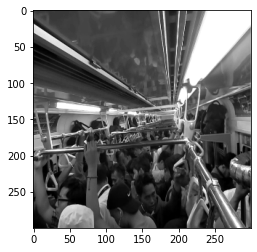

label
tinggi
prediction
tinggi


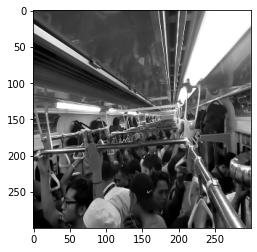

label
tinggi
prediction
rendah


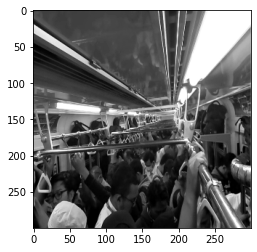

label
tinggi
prediction
tinggi


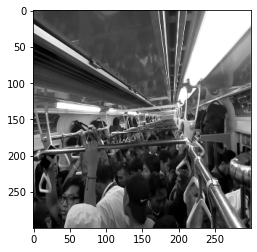

label
tinggi
prediction
tinggi


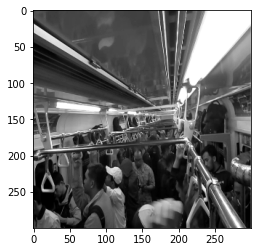

label
tinggi
prediction
rendah


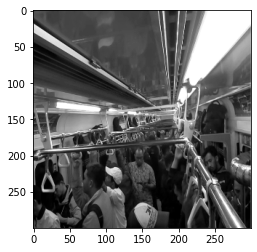

label
tinggi
prediction
rendah


label
tinggi
prediction
rendah


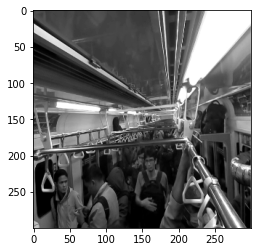

label
tinggi
prediction
tinggi


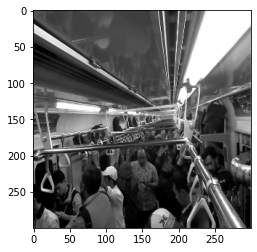

label
tinggi
prediction
tinggi


label
tinggi
prediction
tinggi


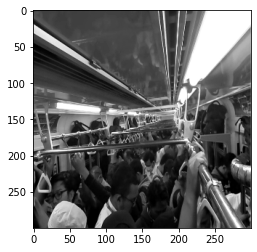

label
tinggi
prediction
tinggi


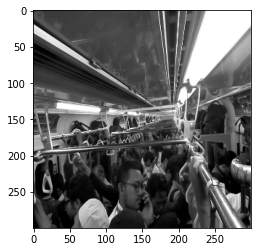

label
tinggi
prediction
tinggi


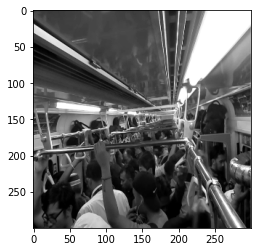

label
tinggi
prediction
tinggi


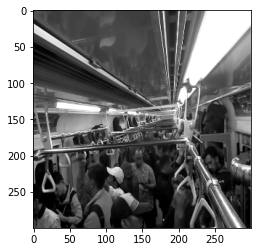

label
tinggi
prediction
tinggi


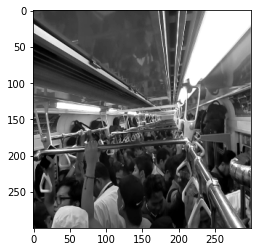

label
tinggi
prediction
tinggi


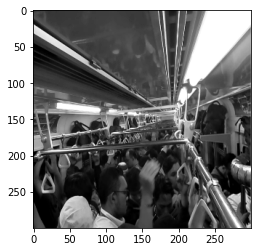

label
tinggi
prediction
tinggi


In [15]:
test_list = []
for category in CATEGORIES:
    # path folder ini
    dirpath = os.path.join(data_path, category)
    # dapatkan list nama file 
    filenames = os.listdir(dirpath)
    # sampling sebanyak jumlah SAMPLE yang ditentukan di konfigurasi
    filenames = random.choices(filenames, k=20)
    
    for filename in filenames:
        path = os.path.join(dirpath, filename)
        img_array = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array, (IMG_H, IMG_W))
        pyplot.imshow(new_array, cmap="gray")
        pyplot.show()
        print("label")
        print(category)
        print("prediction")
        predict(path)
        print("==========")